# `Emotion Detection using Vocal Patterns`

In this project we're finding the emotion of a person by its vocal pattern. To achive this we are training our model with numerous dataset which contain voices of different actors. These are dataset we have:-
* CREMA-D ( Crowd-sourced Emotional Mutimodal Actors Dataset )
  https://www.kaggle.com/datasets/ejlok1/cremad
* RAVDESS ( Ryerson Audio-Visual Database of Emotional Speech and Song  )
    https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
* SAVEE( Surrey Audio-Visual Expressed Emotion )
  https://www.kaggle.com/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee
* TESS( Toronto emotional speech set )
  https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess

`INFORMATION ABOUT DATASET WILL BE AVAILABLE FROM THE GIVEN LINKS`

# 1. Importing Packages

In [1]:
import pandas as pd 
import numpy as np
import os
import sys
import random
import kagglehub
import librosa
import librosa.display

## FOR VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns

# To PLAY AUDIO FILE
from IPython.display import Audio
import tensorflow as  tf
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import keras
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 2. Dataset

## 2.1 Importing Dataset

In [2]:
path = kagglehub.dataset_download("ejlok1/cremad")
path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")
path = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/toronto-emotional-speech-set-tess


## 2.2 Assigning Path

In [3]:
crema = "/kaggle/input/cremad/AudioWAV/"
ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
tess = "/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/"

## 2.3 Dataframe for CREMA

In [4]:
crema_dir = os.listdir(crema)
emotions = []
path_file = []
for audio in crema_dir :
    path_file.append(crema + audio)
    parts = audio.split("_")
    if "ANG" in parts:
        emotions.append("Angry")
    elif "DIS" in parts:
        emotions.append("Disgust")
    elif "FEA" in parts:
        emotions.append("Fear")
    elif "HAP" in parts:
        emotions.append("Happy")
    elif "SAD" in parts:
        emotions.append("Sad")
    elif "NEU" in parts:
        emotions.append("Neutral")
# MAKE THIS INFORMATION INTO DATAFRAME
emotion_df = pd.DataFrame(emotions, columns=["Emotions"])
filePath_df = pd.DataFrame(path_file, columns=["Path"])

crema_df = pd.concat([emotion_df, filePath_df], axis=1)
crema_df.tail(10)

,Emotions,Path
7432,Angry,/kaggle/input/cremad/AudioWAV/1011_TIE_ANG_XX.wav
7433,Happy,/kaggle/input/cremad/AudioWAV/1059_WSI_HAP_XX.wav
7434,Angry,/kaggle/input/cremad/AudioWAV/1033_WSI_ANG_XX.wav
7435,Sad,/kaggle/input/cremad/AudioWAV/1009_WSI_SAD_XX.wav
7436,Angry,/kaggle/input/cremad/AudioWAV/1008_IEO_ANG_MD.wav
7437,Angry,/kaggle/input/cremad/AudioWAV/1060_IEO_ANG_MD.wav
7438,Angry,/kaggle/input/cremad/AudioWAV/1088_IWL_ANG_XX.wav
7439,Angry,/kaggle/input/cremad/AudioWAV/1050_IOM_ANG_XX.wav
7440,Sad,/kaggle/input/cremad/AudioWAV/1044_IWL_SAD_XX.wav
7441,Sad,/kaggle/input/cremad/AudioWAV/1009_ITH_SAD_XX.wav


## 2.4 Dataframe for RAVDESS

In [5]:
ravdess_dir = os.listdir(ravdess)

ravdees_dir =ravdess_dir[0]
emotions = []
path_file = []

for directory in ravdess_dir:
    actor = os.listdir(ravdess + directory)
    for audio in actor:
        file_info = audio.split("-")
        emotions.append(int(file_info[2]))
        path_file.append(ravdess+directory+"/"+audio)
## DATAFRAME
emotions_df = pd.DataFrame(emotions, columns=["Emotions"])
pathFile_df = pd.DataFrame(path_file, columns=["Path"])

ravdess_df = pd.concat([emotions_df, pathFile_df], axis=1)
ravdess_df['Emotions'] = ravdess_df['Emotions'].replace({1:'Neutral', 2:'Calm', 3:'Happy', 4:'Sad', 5:'Angry', 6:'Fear', 7:'Disgust', 8:'Surprise'})
ravdess_df.head()

,Emotions,Path
0,Surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
1,Neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
2,Disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
3,Disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
4,Neutral,/kaggle/input/ravdess-emotional-speech-audio/a...


## 2.5 Dataframe for TESS

In [6]:
tess_dir = os.listdir(tess)
emotions = []
filepath = []

for dir in tess_dir:
    folder = os.listdir(tess+dir)
    for audio in folder:
        #print(audio)
        audio_description = audio.split(".")[0]
        file = audio_description.split("_")
        if file[2] == "ps":
            emotions.append("Surprise")
        else:
            emotions.append(file[2])
        filepath.append(tess+dir+"/"+audio)


emotions_df = pd.DataFrame(emotions, columns=["Emotions"])
pathFile_df = pd.DataFrame(filepath, columns=["Path"])

tess_df = pd.concat([emotions_df, pathFile_df], axis=1)
tess_df['Emotions'] = tess_df['Emotions'].replace({"neutral":'Neutral', "happy":'Happy', "sad":'Sad', "angry":'Angry', "fear":'Fear', 'disgust':'Disgust'})


## 2.6 Clubbing all the Dataframe 

In [7]:
df = pd.concat([crema_df,ravdess_df, tess_df],axis=0)
df.to_csv("data_path.csv",index=False)
df.head()

,Emotions,Path
0,Disgust,/kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav
1,Happy,/kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav
2,Happy,/kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav
3,Disgust,/kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX.wav
4,Disgust,/kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX.wav


# 2. EDA (Exploratory Data Analysis)

## 2.1 Importing and Printing Dataset

In [8]:
df = pd.read_csv("/kaggle/working/data_path.csv")

In [9]:
df.head()

,Emotions,Path
0,Disgust,/kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav
1,Happy,/kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav
2,Happy,/kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav
3,Disgust,/kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX.wav
4,Disgust,/kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX.wav


## Count of Emotions

In [11]:
df.Emotions.value_counts()

Emotions
Disgust     1863
Happy       1863
Sad         1863
Fear        1863
Angry       1863
Neutral     1583
Surprise     592
Calm         192
Name: count, dtype: int64

In [14]:
df.describe()

,Emotions,Path
count,11682,11682
unique,8,11682
top,Disgust,/kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav
freq,1863,1


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11682 entries, 0 to 11681
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Emotions  11682 non-null  object
 1   Path      11682 non-null  object
dtypes: object(2)
memory usage: 182.7+ KB


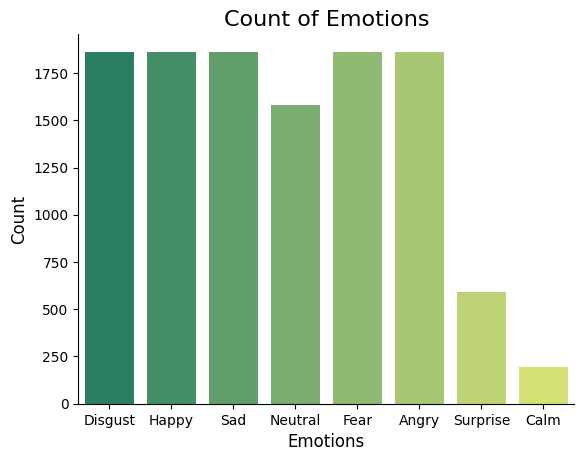

In [18]:
plt.title('Count of Emotions', size=16)
sns.countplot(x = df.Emotions, palette="summer")
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [19]:
def create_waveplot(data, sr, emo, ax=None):
    if ax is not None:
        ax.set_title(f"Waveplot for audio with {emo} emotion")
        librosa.display.waveshow(data, sr=sr, ax=ax)
    else:
        plt.figure(figsize=(10, 5))
        plt.title(f"Waveplot for the audio with {emo} emotion")
        librosa.display.waveshow(data, sr=sr)
        plt.show()

    
def create_spectrogram(data, sr, e, ax=None):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    
    if ax is not None:
        ax.set_title(f"Spectrogram for audio with {e} emotion")
        img = librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz', ax=ax)
        plt.colorbar(img, ax=ax)
    else:
        plt.figure(figsize=(12, 3))
        plt.title(f"Spectrogram for audio with {e} emotion", size=15)
        img = librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
        plt.colorbar(img)
        plt.show()
    
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    
def info_audio(path, emotion):
    data, sampling_rate = librosa.load(path)
    create_waveplot(data, sampling_rate, emotion)
    create_spectrogram(data, sampling_rate, emotion)
    


In [ ]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt

# List of emotions to plot
emotions = ["Sad", "Angry", "Calm", "Happy", "Surprise"]

# Function to create and save waveplot
def create_waveplot(data, sr, emo):
    plt.figure(figsize=(12, 3))  # Size suitable for a full-page spread
    plt.title(f"Waveplot for the audio with {emo} emotion")
    librosa.display.waveshow(data, sr=sr)
    # Save the figure with high DPI for print quality
    plt.savefig(f"{emo}_waveplot.png", bbox_inches="tight", dpi=300)
    plt.close()  # Close the figure to free memory

# Iterate over each emotion to generate and save waveplots
for emotion in emotions:
    # Get the path of an audio file with the specified emotion
    path = np.array(df.Path[df.Emotions == emotion])[1]
    data, sampling_rate = librosa.load(path)
    # Create and save waveplot for the current emotion
    create_waveplot(data, sampling_rate, emotion)


## Feature Extraction

In [ ]:
def extract_feature(file_name, **kwargs):
    """
    Extract feature from audio file `file_name`
        Features supported:
            - MFCC (mfcc)
            - Chroma (chroma)
            - MEL Spectrogram Frequency (mel)
            - Contrast (contrast)
            - Tonnetz (tonnetz)
        e.g:
        `features = extract_feature(path, mel=True, mfcc=True)`
    """
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
   # Load the audio file
    X, sample_rate = librosa.load(file_name, sr=None) 

    
    result = np.array([])

    #  Short-Time Fourier Transform (STFT)
    if chroma or contrast:
        stft = np.abs(librosa.stft(X))

    # Extract MFCCs
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))

    # Extract Chroma features
    if chroma:
        chroma_features = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
        result = np.hstack((result, chroma_features))

    # Extract MEL Spectrogram features
    if mel:
        mel_features = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
        result = np.hstack((result, mel_features))

    # Extract Spectral Contrast features
    if contrast:
        contrast_features = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
        result = np.hstack((result, contrast_features))

    # Extract Tonnetz features 
    if tonnetz:
        tonnetz_features = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T, axis=0)
        result = np.hstack((result, tonnetz_features))

    return result
def get_features(row):
    # Extract features with all specified feature types
    features = extract_feature(row['Path'], mfcc=True, chroma=True, mel=True, contrast=True, tonnetz=True)
    return features

## Running the code

In [ ]:

feature_data = []


for _, row in df.iterrows():
    features = get_features(row)   
    label = row['Emotions']          
    feature_data.append([*features, label])  

column_names = [f'feature_{i}' for i in range(len(features))] + ['Emotions']
features_df = pd.DataFrame(feature_data, columns=column_names)


print(features_df)
features_df.to_csv("Data/audio_feature_extracted.csv", index=False)

# Opening Feature Dataset

In [3]:
audio_feature_extracted_path = kagglehub.dataset_download('adithyasanthosh13/audio-feature-extracted')

In [2]:
features_df = pd.read_csv("/kaggle/input/audio-feature-extracted/audio_feature_extracted.csv")
features_df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_184,feature_185,feature_186,feature_187,feature_188,feature_189,feature_190,feature_191,feature_192,Emotions
0,-306.027405,92.670235,8.491312,23.965403,7.477992,-5.759456,-11.883088,-9.676736,-3.996747,-13.352564,...,18.893692,18.224082,14.604481,-0.015898,0.003817,0.007877,-0.120277,0.008830,-0.007747,Angry
1,-346.399628,95.839119,10.516282,31.619215,15.872088,-6.845447,-6.629935,-4.978727,-5.310654,-10.283518,...,17.801306,17.213798,14.839619,-0.017237,-0.033240,-0.057023,-0.054222,0.019257,0.003255,Disgust
2,-321.420258,94.760910,8.155397,23.323242,11.719158,-7.116332,-8.534803,-4.996966,-4.994400,-13.706510,...,18.462014,16.960637,14.897810,-0.010351,0.052390,-0.029822,-0.035096,0.026566,0.008660,Fear
3,-303.303741,92.528893,4.231231,27.970133,10.869824,-11.878345,-10.095112,-7.149730,-7.651760,-17.085901,...,19.229368,17.731477,14.610380,-0.004995,0.051140,-0.064492,-0.038157,-0.012475,0.006861,Happy
4,-335.495911,100.393311,9.384935,30.160906,11.466775,-3.333670,-8.350987,-9.757346,-6.079327,-12.109531,...,18.472572,18.171643,14.501908,0.022135,0.009803,-0.022709,-0.079063,0.019946,-0.002474,Neutral


## Removing unwanted Labels


In [3]:
mask = ~features_df['Emotions'].isin(['Fear', 'Disgust', "Neutral"])
features_df = features_df[mask]

## Splitting of Data

In [4]:
features_df.shape

(6373, 194)

In [4]:
from sklearn.model_selection import train_test_split


X = features_df.drop('Emotions', axis=1) 
y = features_df['Emotions']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=99) #69,99

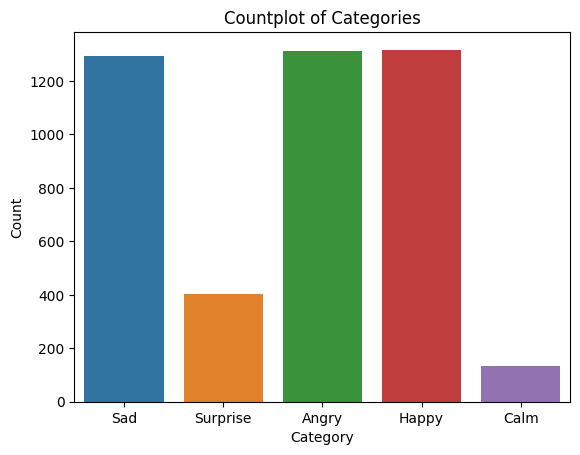

In [6]:
sns.countplot(x=y_train)

# Customize the plot (optional)
plt.title('Countplot of Categories')
plt.xlabel('Category')
plt.ylabel('Count')

# Show the plot
plt.show()

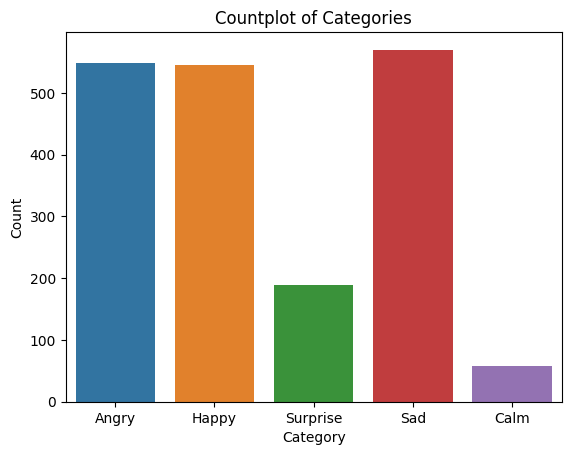

In [93]:
sns.countplot(x=y_test)

# Customize the plot (optional)
plt.title('Countplot of Categories')
plt.xlabel('Category')
plt.ylabel('Count')

# Show the plot
plt.show()

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Label Encoder

In [5]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)
print("Encoded labels:", y_train)
list_label_print = list(zip(encoder.classes_, encoder.transform(encoder.classes_)))

print("Mapping of labels:",list_label_print )

Encoded labels: [3 4 0 ... 0 4 1]
Mapping of labels: [('Angry', 0), ('Calm', 1), ('Happy', 2), ('Sad', 3), ('Surprise', 4)]


## One Hot Encoding (For our Model)

In [8]:
X_test.shape

(1912, 193)

In [7]:
encoder = OneHotEncoder()
y_train = encoder.fit_transform(np.array(y_train).reshape(-1,1)).toarray()
y_test = encoder.fit_transform(np.array(y_test).reshape(-1,1)).toarray()

In [31]:
## 
y_train.dtype

dtype('float64')

## Model

In [14]:
## 
X_train.shape[1]

193

In [18]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

# Define the model architecture
model = Sequential([
    InputLayer(input_shape=(X_train.shape[1], 1)),
    
    Conv1D(256, 5, strides=1, activation='relu', kernel_regularizer=l2(0.001)),
    Conv1D(128, 5, strides=1, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    
    Conv1D(128, 5, strides=1, activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling1D(pool_size=8, strides=1),
    Dropout(0.4),
    
    Flatten(),
    
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),# earlier 4
    Dense(5, activation='softmax')  # Adjust output units based on classes
])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_15 (Conv1D)              │ (None, 189, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 185, 128)       │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 185, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 185, 128)       │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 185, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 185, 64)        │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 185, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 181, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 174, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 174, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 22272)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │     5,701,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,934,533 (22.64 MB)

 Trainable params: 5,934,533 (22.64 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:

from tensorflow.keras.optimizers import Adam

adamw = Adam(learning_rate=0.00001, weight_decay=1e-7)
model.compile(loss='categorical_crossentropy', optimizer=adamw, metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


## Cross validation


In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
encoder = OneHotEncoder()
y_train = encoder.fit_transform(np.array(y_train).reshape(-1,1)).toarray()
y_test = encoder.fit_transform(np.array(y_test).reshape(-1,1)).toarray()

In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
def model_creation():
    model = Sequential([
        InputLayer(input_shape=(X_train.shape[1], 1)),
        
        Conv1D(256, 5, strides=1, activation='relu', kernel_regularizer=l2(0.001)),
        Conv1D(128, 5, strides=1, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.3),
        
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        
        Conv1D(128, 5, strides=1, activation='relu', kernel_regularizer=l2(0.001)),
        MaxPooling1D(pool_size=8, strides=1),
        Dropout(0.4),
        
        Flatten(),
        
        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(5, activation='softmax')  # Adjust output units based on classes
    ])
    adamw = Adam(learning_rate=0.00001, weight_decay=1e-7)
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=adamw, metrics=['accuracy'])
    return model

# Cross-Validation
fold_no = 1
n_splits = 10
skf = KFold(n_splits=n_splits, shuffle=True, random_state=99)
fold_losses = []
fold_accuracies = []
X_ = X.values if isinstance(X, pd.DataFrame) else X
y_ = y.values if isinstance(y, pd.Series) else y
encoder = LabelEncoder()

for train_index, val_index in skf.split(X_, y_):
    print(f"Training fold {fold_no}...")
    
    # Split data
    if isinstance(X_, pd.DataFrame):
        X_train, X_val = X_.iloc[train_index], X_.iloc[val_index]
        y_train, y_val = y_.iloc[train_index], y_.iloc[val_index]
    else:
        X_train, X_val = X_[train_index], X_[val_index]
        y_train, y_val = y_[train_index], y_[val_index]
    
    # Reshape and encode
    X_train = np.expand_dims(X_train, axis=-1)
    X_val = np.expand_dims(X_val, axis=-1)
    y_train = encoder.fit_transform(y_train)
    y_val = encoder.transform(y_val)
    
    # Create model
    model = model_creation()

    # Train
    history = model.fit(
        X_train, y_train,
        epochs=200,
        batch_size=32,
        validation_data=(X_val, y_val),
        verbose=1
    )

    # Evaluate
    scores = model.evaluate(X_val, y_val, verbose=0)
    print(f"Fold {fold_no} - Loss: {scores[0]} - Accuracy: {scores[1]}")
    fold_losses.append(scores[0])
    fold_accuracies.append(scores[1])
    
    fold_no += 1

# Aggregated Results
print("\nCross-Validation Results:")
print(f"Mean Loss: {np.mean(fold_losses):.4f} ± {np.std(fold_losses):.4f}")
print(f"Mean Accuracy: {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")


Training fold 1...
Epoch 1/200


I0000 00:00:1737782759.588775     102 service.cc:145] XLA service 0x5c06c1827b70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737782759.588827     102 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1737782759.588831     102 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1737782774.072412     129 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2', 1080 bytes spill stores, 1080 bytes spill loads

I0000 00:00:1737782776.885760     128 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_3', 1112 bytes spill stores, 1112 bytes spill loads



 18/180 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2462 - loss: 2.8902

I0000 00:00:1737782783.458623     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


174/180 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4030 - loss: 2.4082

I0000 00:00:1737782797.465119     178 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_3', 1112 bytes spill stores, 1112 bytes spill loads



180/180 ━━━━━━━━━━━━━━━━━━━━ 57s 173ms/step - accuracy: 0.4052 - loss: 2.4019 - val_accuracy: 0.5580 - val_loss: 2.2563
Epoch 2/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5153 - loss: 2.1019 - val_accuracy: 0.5846 - val_loss: 2.1930
Epoch 3/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5576 - loss: 2.0074 - val_accuracy: 0.6207 - val_loss: 2.1408
Epoch 4/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5917 - loss: 1.9293 - val_accuracy: 0.6395 - val_loss: 2.0833
Epoch 5/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6013 - loss: 1.8722 - val_accuracy: 0.6458 - val_loss: 2.0307
Epoch 6/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6098 - loss: 1.8412 - val_accuracy: 0.6505 - val_loss: 1.9891
Epoch 7/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6268 - loss: 1.7877 - val_accuracy: 0.6991 - val_loss: 1.9394
Epoch 8/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6260 - loss: 1.7777 - val_accuracy: 0.6

I0000 00:00:1737783649.031958    9891 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_3', 1112 bytes spill stores, 1112 bytes spill loads



180/180 ━━━━━━━━━━━━━━━━━━━━ 36s 150ms/step - accuracy: 0.4074 - loss: 2.3473 - val_accuracy: 0.5683 - val_loss: 2.2779
Epoch 2/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5158 - loss: 2.1092 - val_accuracy: 0.5636 - val_loss: 2.2160
Epoch 3/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5430 - loss: 2.0371 - val_accuracy: 0.5808 - val_loss: 2.1501
Epoch 4/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5770 - loss: 1.9655 - val_accuracy: 0.6044 - val_loss: 2.1204
Epoch 5/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5965 - loss: 1.9158 - val_accuracy: 0.6185 - val_loss: 2.0729
Epoch 6/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5880 - loss: 1.8932 - val_accuracy: 0.6232 - val_loss: 2.0282
Epoch 7/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6115 - loss: 1.8360 - val_accuracy: 0.6279 - val_loss: 1.9719
Epoch 8/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6135 - loss: 1.7946 - val_accuracy: 0.6

In [ ]:
import matplotlib.pyplot as plt

# Example data
folds = [1, 2, 3,4,5]

# Accuracy plot
plt.figure(figsize=(10, 5))
plt.plot(folds, fold_accuracies[:5], marker='o', label='Accuracy')
plt.plot(folds, fold_losses[:5], marker='o', label='Loss', linestyle='--')
plt.title("Metrics Across Folds")
plt.xlabel("Fold")
plt.ylabel("Metric Value")
plt.legend()
plt.grid(True)
plt.show()

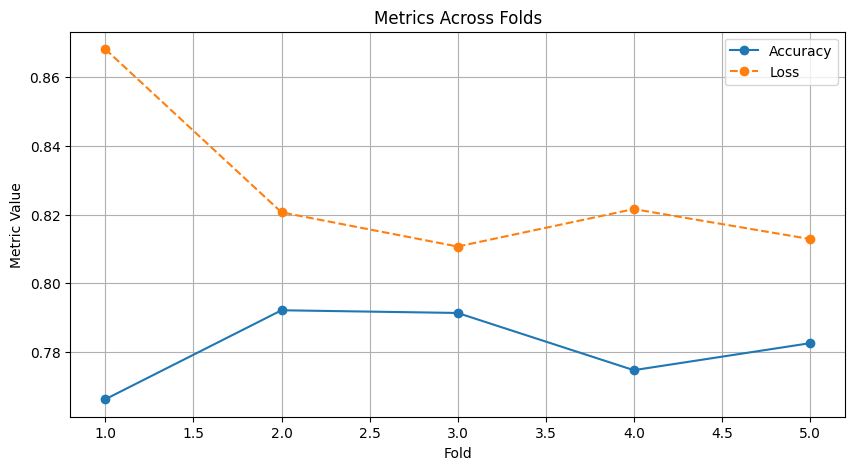

In [11]:
import matplotlib.pyplot as plt

# Example data
folds = [1, 2, 3, 4, 5]

# Accuracy plot
plt.figure(figsize=(10, 5))
plt.plot(folds, fold_accuracies, marker='o', label='Accuracy')
plt.plot(folds, fold_losses, marker='o', label='Loss', linestyle='--')
plt.title("Metrics Across Folds")
plt.xlabel("Fold")
plt.ylabel("Metric Value")
plt.legend()
plt.grid(True)
plt.show()


## Training

In [51]:
history = model.fit(
    X_train, y_train,
    epochs=400,  #350
    batch_size=16,
    validation_data=(X_test, y_test)
)


Epoch 1/400
279/279 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.4154 - loss: 2.4436 - val_accuracy: 0.5413 - val_loss: 2.2238
Epoch 2/400
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5171 - loss: 2.1082 - val_accuracy: 0.5591 - val_loss: 2.1889
Epoch 3/400
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5259 - loss: 2.0691 - val_accuracy: 0.6036 - val_loss: 2.1438
Epoch 4/400
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5636 - loss: 1.9760 - val_accuracy: 0.6182 - val_loss: 2.0975
Epoch 5/400
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5852 - loss: 1.9262 - val_accuracy: 0.6318 - val_loss: 2.0717
Epoch 6/400
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5969 - loss: 1.9015 - val_accuracy: 0.6386 - val_loss: 2.0450
Epoch 7/400
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5927 - loss: 1.8615 - val_accuracy: 0.6428 - val_loss: 1.9963
Epoch 8/400
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6127 - loss: 1.8161 - val_ac

In [52]:
# Evaluate model performance
val_loss, val_accuracy = model.evaluate(X_test, y_test)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8080 - loss: 0.7108
Validation Loss: 0.7176705002784729
Validation Accuracy: 0.8023012280464172


In [48]:
model.save('my_model.h5')

In [ ]:
model = tf.keras.models.load_model('/kaggle/input/ann/tensorflow2/default/1/my_model.h5')

## Report

In [53]:
from sklearn.metrics import classification_report
import numpy as np

y_pred = model.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
class_names = [str(i) for i in range(5)] 
report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print(report)



60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

           0       0.82      0.78      0.80       549
           1       0.70      0.79      0.74        58
           2       0.70      0.73      0.71       546
           3       0.87      0.87      0.87       570
           4       0.87      0.89      0.88       189

    accuracy                           0.80      1912
   macro avg       0.79      0.81      0.80      1912
weighted avg       0.80      0.80      0.80      1912



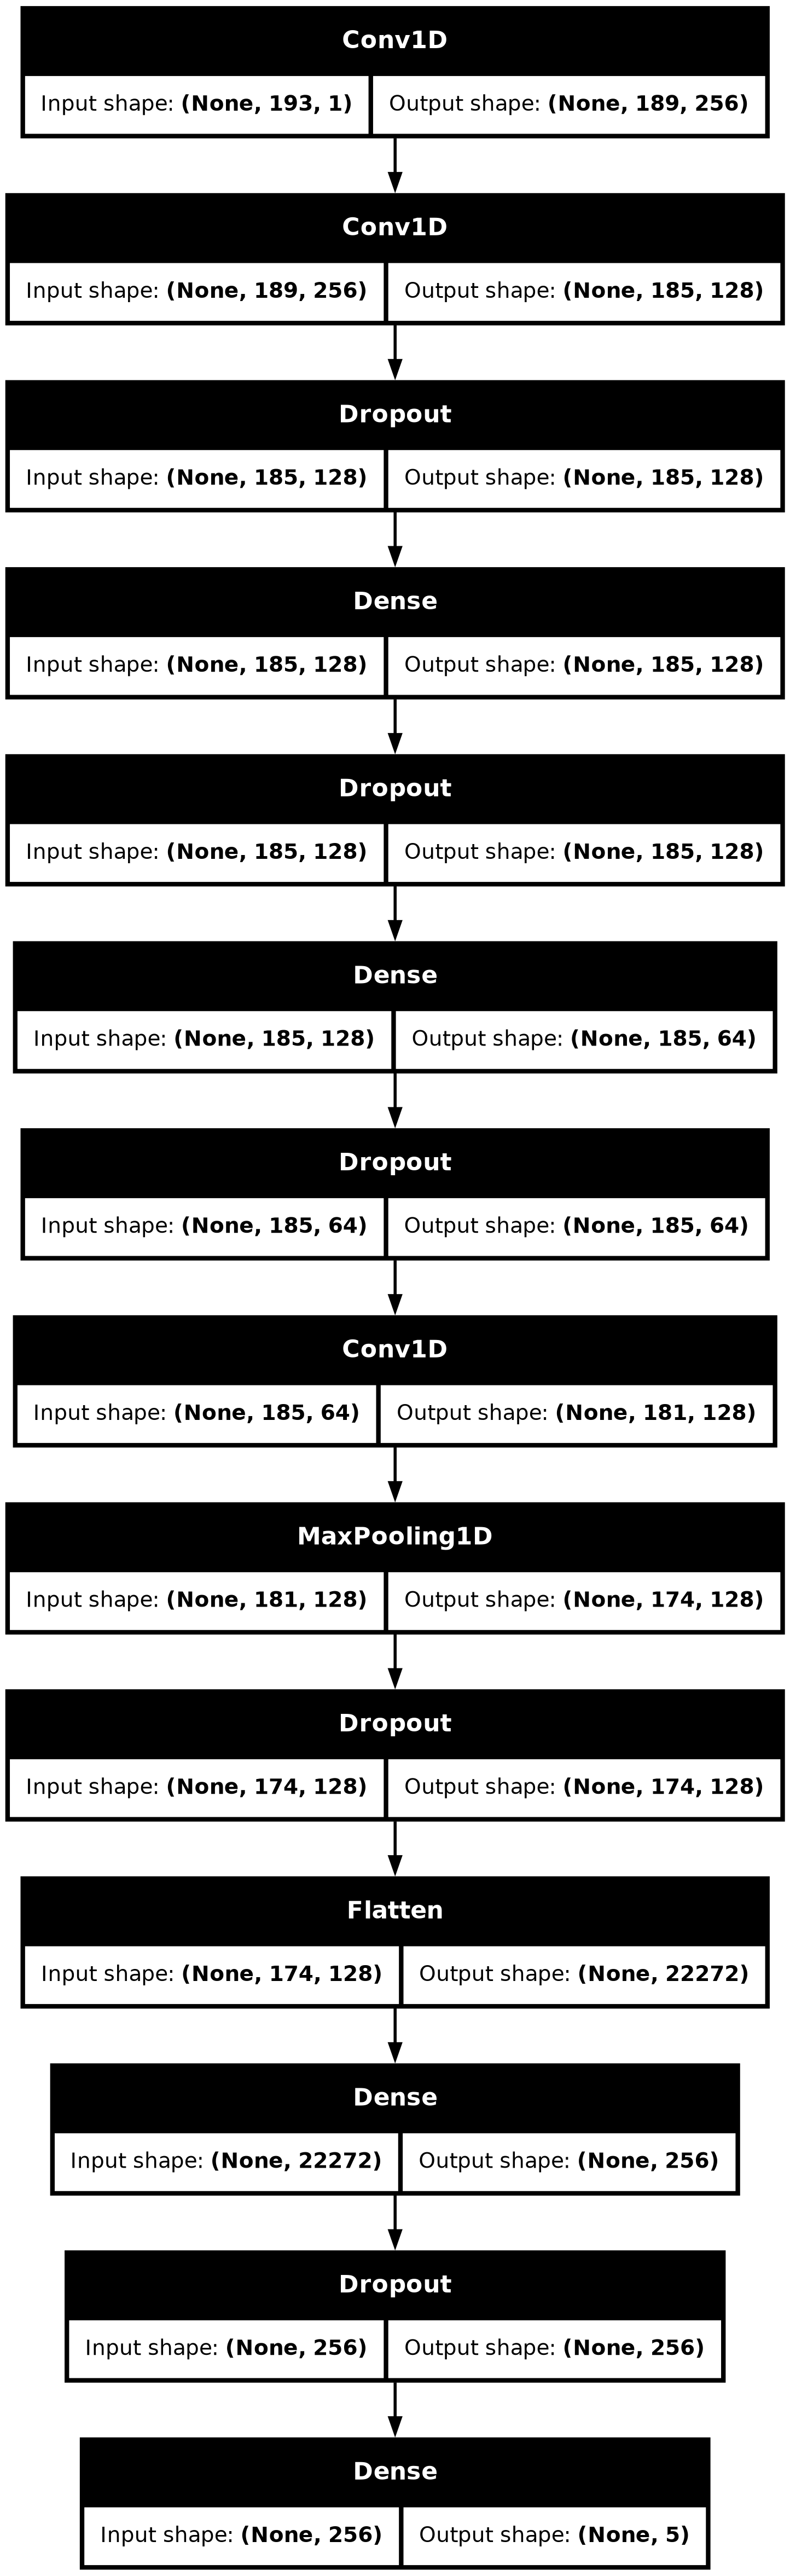

In [18]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file="model.png", show_shapes=True)

## Accuracy of each Label

In [54]:
print(list_label_print)  
label_mapping = ["Angry","Calm","Happy","Sad","Surprise"]

[('Angry', 0), ('Calm', 1), ('Happy', 2), ('Sad', 3), ('Surprise', 4)]


In [55]:

report = classification_report(y_true_classes, y_pred_classes, target_names=class_names, output_dict=True)
# Extract precision for each class
for class_label, metrics in report.items():
    if class_label != 'accuracy' and class_label != 'macro avg' and class_label != 'weighted avg':
        print(f"Accuracy for class {class_label}: {metrics['precision']:.2f}")

Accuracy for class 0: 0.82
Accuracy for class 1: 0.70
Accuracy for class 2: 0.70
Accuracy for class 3: 0.87
Accuracy for class 4: 0.87


In [63]:
df = pd.DataFrame(report).transpose()

# Style the DataFrame
formatted_df = df.to_string(formatters={'f2': '{:.2f}'.format}) 
df.style.background_gradient(cmap='coolwarm') \
    .format('{:.2f}') \
    .set_table_styles([{'selector': 'th', 'props': [('font-size', '11pt')]},
                       {'selector': 'td', 'props': [('font-size', '10pt')]}]) \
    .highlight_max(color='lightgreen', axis=0) \
    .highlight_min(color='lightcoral', axis=0)

# Display the styled DataFrame
display(df)

,precision,recall,f1-score,support
Angry,0.824324,0.777778,0.800375,549.000000
Calm,0.696970,0.793103,0.741935,58.000000
Happy,0.700704,0.728938,0.714542,546.000000
Sad,0.872792,0.866667,0.869718,570.000000
Surprise,0.871134,0.894180,0.882507,189.000000
accuracy,0.802301,0.802301,0.802301,0.802301
macro avg,0.793185,0.812133,0.801815,1912.000000
weighted avg,0.804236,0.802301,0.802882,1912.000000


In [36]:
import pandas as pd

# Create a DataFrame with the given values
data = {'Emotion':["Angry","Calm","Happy","Sad","Surprise"],
        'precision': [0.77, 0.60, 0.73, 0.86, 0.89],
        'recall': [0.84, 0.81, 0.65, 0.85, 0.91],
        'f1-score': [0.80, 0.69, 0.68, 0.85, 0.90],
        'support': [549.0, 58.0, 546.0, 570.0, 189.0]}

df = pd.DataFrame(data)

# Replace the index with emotion labels



df

,Emotion,precision,recall,f1-score,support
0,Angry,0.77,0.84,0.80,549.0
1,Calm,0.60,0.81,0.69,58.0
2,Happy,0.73,0.65,0.68,546.0
3,Sad,0.86,0.85,0.85,570.0
4,Surprise,0.89,0.91,0.90,189.0


In [ ]:
import pandas as pd

# Create a DataFrame with the given values and formatting
data = {'Emotion': ['Angry', 'Calm', 'Happy', 'Sad', 'Surprise'],
        'precision': [0.824324, 0.696970, 0.700704, 0.872792, 0.871134],
        'recall': [0.777778, 0.793103, 0.728938, 0.866667, 0.894180],
        'f1-score': [0.800375, 0.741935, 0.714542, 0.869718, 0.882507],
        'support': [549.000000, 58.000000, 546.000000, 570.000000, 189.000000]}

df = pd.DataFrame(data)

# Format the DataFrame for better readability
df = df.style.format({'precision': '{:.2f}', 'recall': '{:.2f}', 'f1-score': '{:.2f}', 'support': '{:.0f}'})

# Display the formatted DataFrame
print(df)

## Confusion Matrix

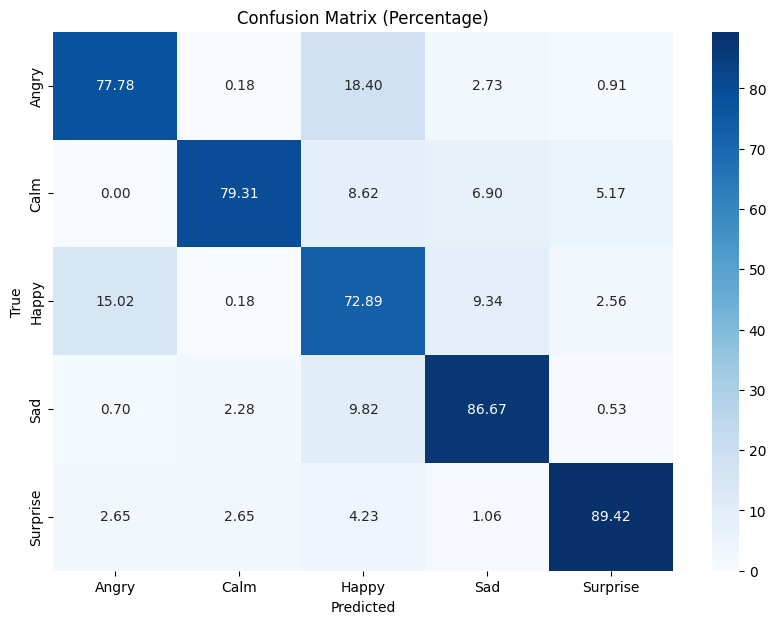

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred_classes are defined
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Normalize confusion matrix to get percentages
norm_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 7))
sns.heatmap(norm_conf_matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels=label_mapping, yticklabels=label_mapping)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Percentage)")  # Update title to reflect percentages
plt.show()

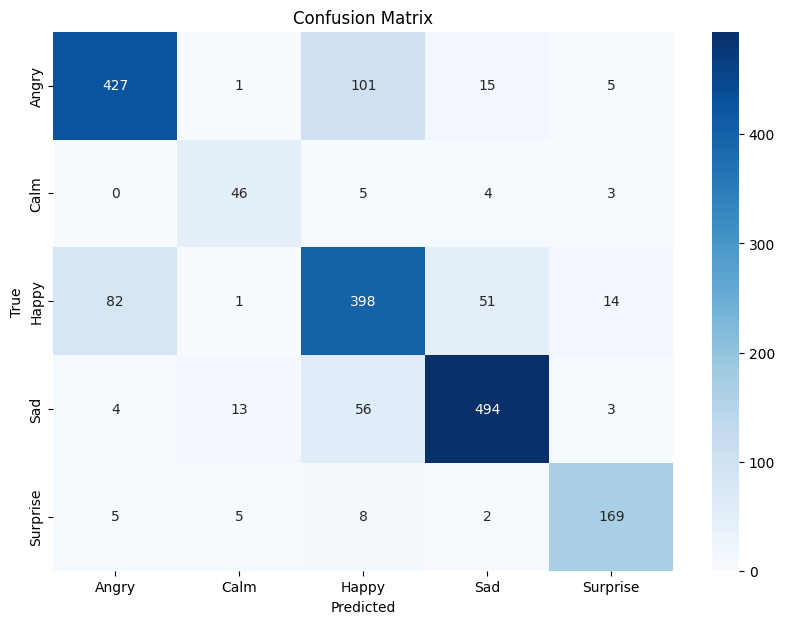

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred_classes are defined
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping, yticklabels=label_mapping)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


## Classification Report Visualization

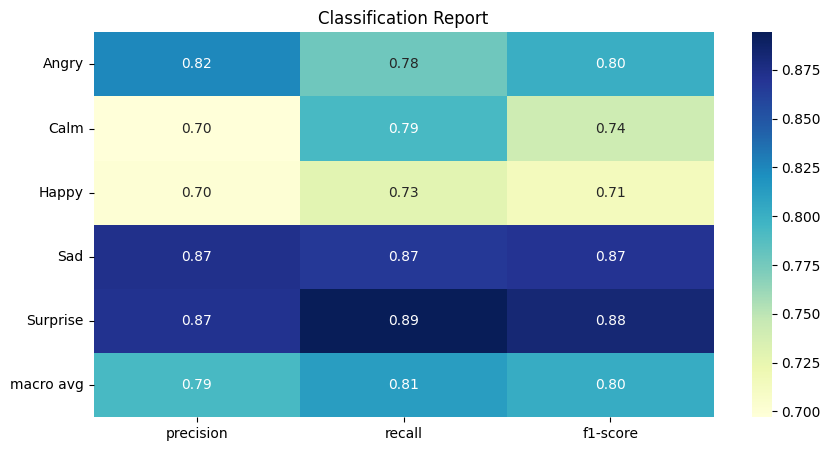

In [57]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_true_classes, y_pred_classes, target_names=label_mapping, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.drop("accuracy", inplace=True)  # Drop the accuracy row if needed

plt.figure(figsize=(10, 5))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Classification Report")
plt.show()


## Accuracy and Loss

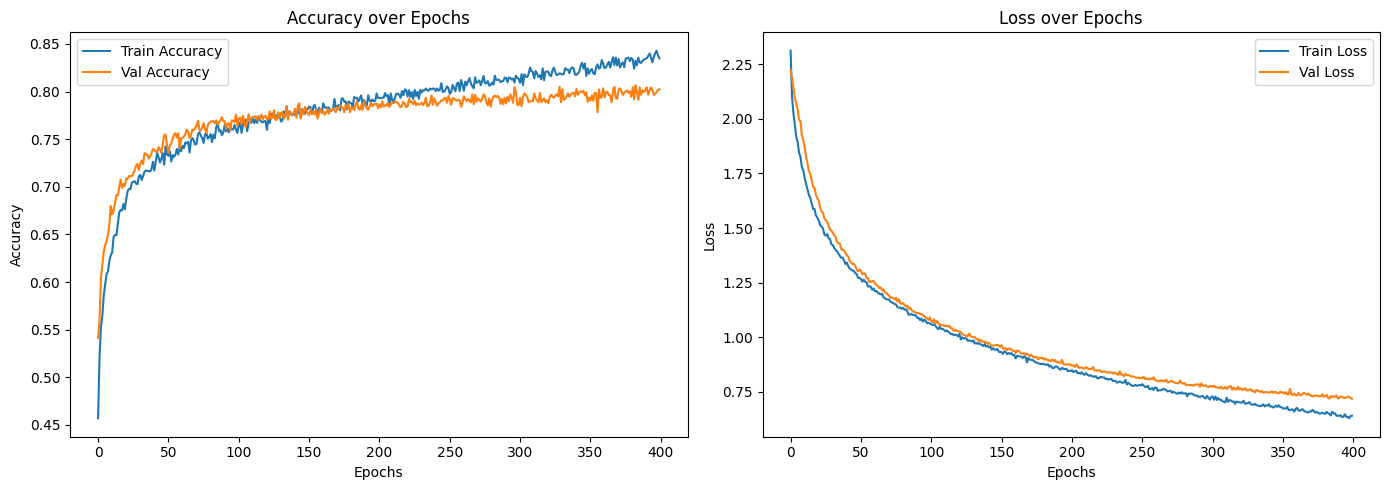

In [58]:
# Assuming `history` is the history object from model training
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## Precision-Recall Curve

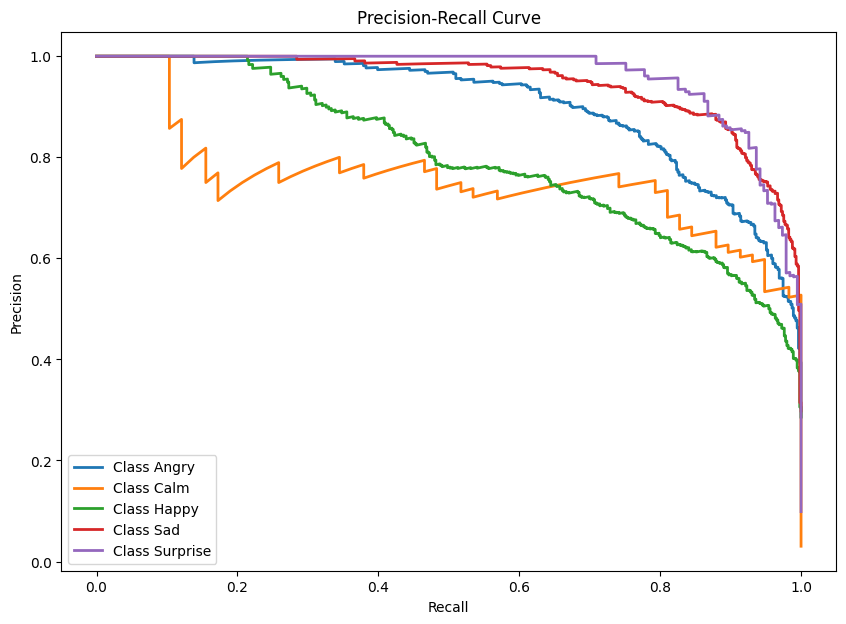

In [59]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# Binarize y_test if not done (for multi-class precision-recall curve)
y_test_bin = label_binarize(y_test, classes=range(len(label_mapping)))
precision = dict()
recall = dict()

plt.figure(figsize=(10, 7))
for i, label in enumerate(label_mapping):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_pred[:, i])
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {label}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.show()


## ROC Curve


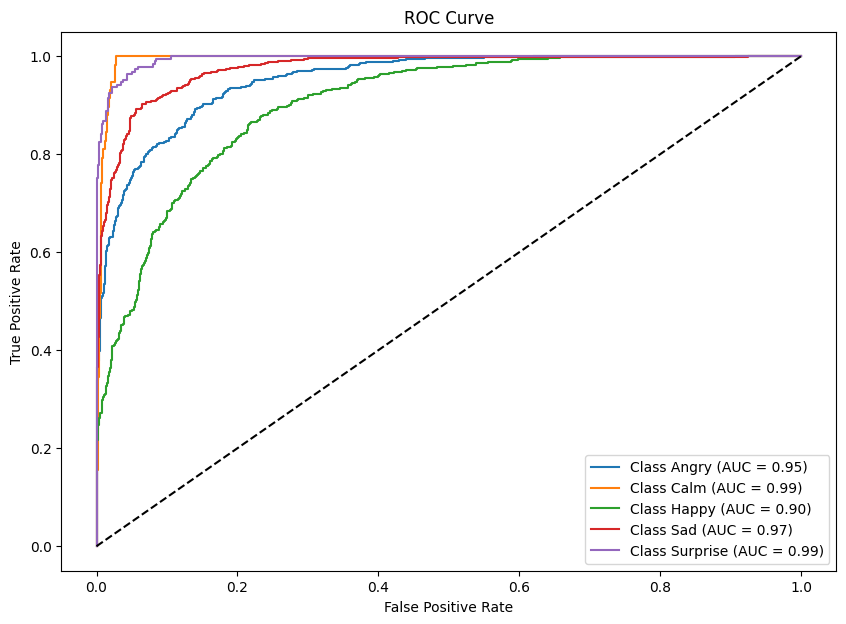

In [60]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 7))
for i, label in enumerate(label_mapping):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {label} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="best")
plt.show()


## Model Prediction Confidence Histogram

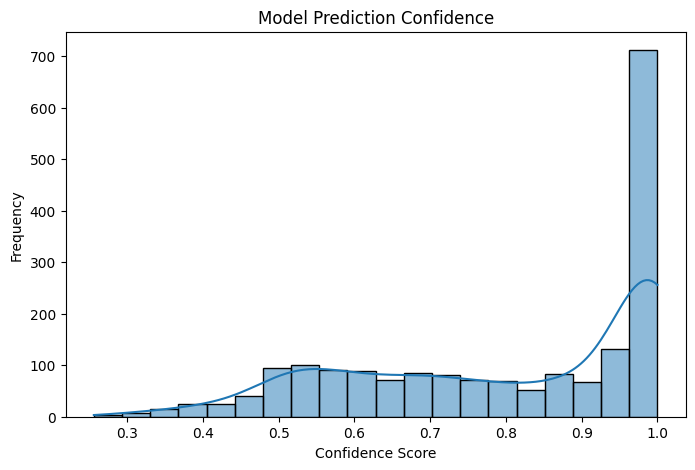

In [61]:
confidence_scores = np.max(y_pred, axis=1)  # Assuming y_pred_prob is the probability output from model
plt.figure(figsize=(8, 5))
sns.histplot(confidence_scores, bins=20, kde=True)
plt.title("Model Prediction Confidence")
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.show()


## t--SNE or PCA for Embedding Visualization

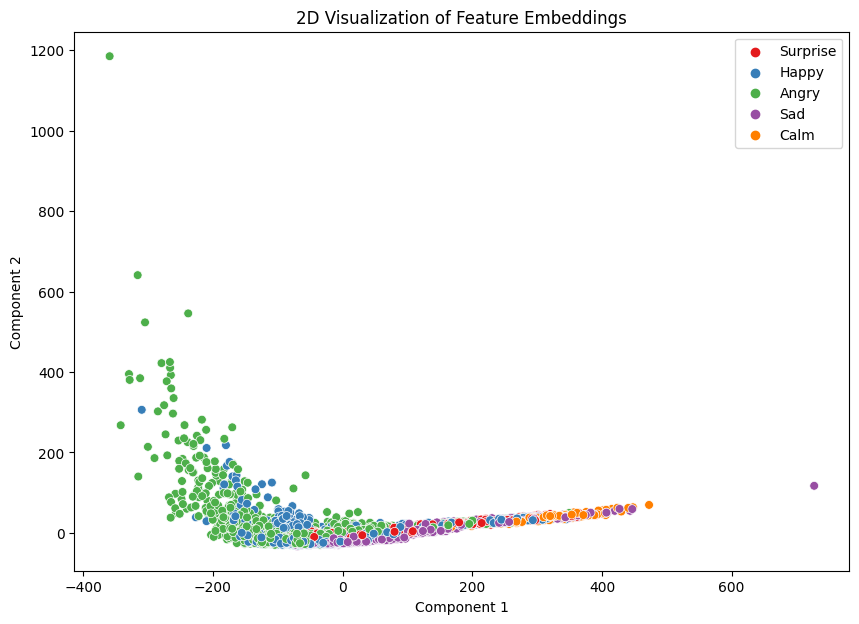

In [32]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Reduce dimensionality for visualization (choose one of PCA or t-SNE)
X_reduced = PCA(n_components=2).fit_transform(X_train)  # or TSNE(n_components=2).fit_transform(features)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=y_train, palette="Set1", s=40)
plt.title("2D Visualization of Feature Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(loc="best")
plt.show()
